This notebook will have the model architecture and traffic generation code in it.

As well as some final evaluation of a chosen attack.

In [1]:
#Importing required modules and libraries.

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier as gboost, RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_squared_error,
                             classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve)

from sklearn.preprocessing import LabelEncoder

from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.layers import Activation
from keras.optimizers import RMSprop
from keras.layers.merge import _Merge
from keras import backend as K
from keras.models import load_model
from functools import partial


BATCH_SIZE = 1024

#Defining functions 

def scalex(X):
    """ normalize between 0 and 1 the values in X """
    nmin, nmax = 0.0, 1.0
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (nmax - nmin) + nmin
    return X_scaled

def wasserstein_loss(y_true, y_pred):
    """ Wasserstein distance """
    return K.mean(y_true * y_pred)

def calcrmse(X_train, gensamples):
    """ compute mse for training """
    max_column = X_train.shape[1]
    rmse_lst = []
    for col in range(max_column):
        rmse_lst.append(np.sqrt(mean_squared_error(X_train[:,col], gensamples[:,col])))
    return np.sum(rmse_lst) / max_column

def gradient_penalty_loss(y_true, y_pred, averaged_samples, lamba_reg):
    """ compute gradient penalty loss for GP-WGAN """
    gradients = K.gradients(y_pred, averaged_samples)[0]
    gradients_sqr = K.square(gradients)
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    gradient_penalty = lamba_reg * K.square(1 - gradient_l2_norm)
    return K.mean(gradient_penalty)

class RandomWeightedAverage(_Merge):
    def _merge_function(self, inputs):
        weights = K.random_uniform((BATCH_SIZE, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])

def generate_samples(generator_model, noise_dim, num_samples):
    """ generate samples to be used for futher analysis """
    return generator_model.predict(np.random.rand(num_samples, noise_dim))

def create_normalized_dataframe(df, attack_name):
    df_new = df.loc[df[" Label"] == attack_name]

    features = []
    for n in range(len(lbl)-1):
        m = lbl[n]
        tmp = np.unique(df_new[m])
        if (len(tmp) > 1):
            features.append(m)

    # normalize each field independently
    df_attack_norm = df_new
    for n in range(len(lbl)-1):
        m = lbl[n]
        if (np.max(df_attack_norm[m]) > 1).any(): 
            if (len(np.unique(df_attack_norm[m])) > 1):
                df_attack_norm[m] = scalex(df_attack_norm[m])
            else:
                df_attack_norm[m] = np.int64(1)  

    return df_attack_norm


#Reading the csv with network traffic into a pandas dataframe df.
df = pd.read_csv('./data/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv', sep=",", header=None, low_memory=False)

#Getting rid of NaN values in the df.
df = df.dropna()

#Assigning column names.
df.columns = df.iloc[0]
df = df[1:]

#Setting the data types for each column.
df = df.apply(pd.to_numeric, errors='ignore')

#Listing the attacks present in the .csv and the number of samples for each attack type.
label_counts = df[' Label'].value_counts()
print(label_counts)

#Assigning columns names to the lbl dataframe.
lbl = df.columns

#Checking for any NaN values inside the dataframe.
print(df.isna().sum())

Using TensorFlow backend.
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)

BENIGN         431873
FTP-Patator      7938
SSH-Patator      5897
Name:  Label, dtype: int64
0
 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label                         0
Length: 79, dtype: int64


In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

#Assigning the attack name.

#attack_name = "DoS slowloris"
#attack_name = "DoS Hulk"
attack_name = "SSH-Patator"
#attack_name = "DoS GoldenEye"
#attack_name = "FTP-Patator"
#attack_name = "Web Attack  XSS"

#Normalising the dataframe for a specific attack type before using it to generate data.
df_attack_norm = create_normalized_dataframe(df, attack_name)
#Deleting NaN values.
df_attack_norm = df_attack_norm.dropna()

# Building GP-WGAN and generate adversarial samples.
#
#Model hyperparameters.
BATCH_SIZE = 1024
GRADIENT_PENALTY_WEIGHT = 10 #0.1
MAX_SIM = 5897 #1500 #10293 #10000
MAX_EPOCH = 5000 #15000 6500
TRAINING_RATIO = 3
NUM_SAMPLES = 2000 #5000

#Taking training data from the dataset excluding the Label column.
X_train = np.asarray(df_attack_norm.iloc[:MAX_SIM, :-1])
np.random.shuffle(X_train)

#
### Building the model
def make_generator(noise_dim):
    model = Sequential()
    model.add(Dense(256,  kernel_initializer='he_normal', input_dim=INPUT_DIM))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(128,  kernel_initializer='he_normal'))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(128,  kernel_initializer='he_normal'))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(128,  kernel_initializer='he_normal'))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(units=noise_dim, activation='linear'))
    return model
  
def make_discriminator():
    model = Sequential()
    model.add(Dense(256, kernel_initializer='he_normal', input_dim=INPUT_DIM))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(128, kernel_initializer='he_normal', input_dim=INPUT_DIM))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(128, kernel_initializer='he_normal', input_dim=INPUT_DIM))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(128, kernel_initializer='he_normal', input_dim=INPUT_DIM))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(units=1, activation='linear'))
    return model

#The input dimension is the number of generated features in the dataset.
INPUT_DIM = X_train.shape[1]
noise_dim = INPUT_DIM

generator = make_generator(noise_dim)
discriminator = make_discriminator()


#### for the generator it is mostly the same as WGAN std
for layer in discriminator.layers:
    layer.trainable = False
discriminator.trainable = False

generator_input = Input(shape=(noise_dim,))
generator_layers = generator(generator_input)
discriminator_layers_for_generator = discriminator(generator_layers)

generator_model = Model(inputs=[generator_input], outputs=[discriminator_layers_for_generator])
generator_model.compile(optimizer=RMSprop(lr = 0.005, rho = 0.9, epsilon=1e-6), loss = wasserstein_loss)


#### New discriminator model for GPWGAN
for layer in discriminator.layers:
    layer.trainable = True
for layer in generator.layers:
    layer.trainable = False
discriminator.trainable = True
generator.trainable = False 


real_samples = Input(shape=X_train.shape[1:])
generator_input_for_discriminator = Input(shape=(noise_dim,))
generated_samples_for_discriminator = generator(generator_input_for_discriminator)
discriminator_output_from_generator = discriminator(generated_samples_for_discriminator)
discriminator_output_from_real_samples = discriminator(real_samples)

averaged_samples = RandomWeightedAverage()([real_samples, generated_samples_for_discriminator])
averaged_samples_out = discriminator(averaged_samples)

discriminator_model = Model(inputs=[real_samples, generator_input_for_discriminator], 
                            outputs=[discriminator_output_from_real_samples, discriminator_output_from_generator, 
                                     averaged_samples_out])


### the loss function takes more inputs than the standard y_true and y_pred 
### values usually required for a loss function. Therefore, we will make it partial.
partial_gp_loss = partial(gradient_penalty_loss, averaged_samples=averaged_samples, lamba_reg=GRADIENT_PENALTY_WEIGHT)
partial_gp_loss.__name__ = 'gp_loss' 


# finally, we compile the model
discriminator_model.compile(optimizer=RMSprop(lr=0.005, rho=0.9, epsilon=1e-6), loss=[wasserstein_loss, wasserstein_loss, partial_gp_loss])



positive_y = np.ones((BATCH_SIZE, 1), dtype=np.float32)
negative_y = -positive_y
dummy_y = np.zeros((BATCH_SIZE, 1), dtype=np.float32) # dummy vector mandatory for the train on batch function

#Training the GAN and displaying training process every 100 epochs.

for epoch in range(MAX_EPOCH + 1):
    np.random.shuffle(X_train)

    minibatches_size = BATCH_SIZE * TRAINING_RATIO
    for i in range(int(X_train.shape[0] // (BATCH_SIZE * TRAINING_RATIO))):
        discriminator_minibatches = X_train[i * minibatches_size:(i + 1) * minibatches_size]
        for j in range(TRAINING_RATIO):
            sample_batch = discriminator_minibatches[j * BATCH_SIZE:(j + 1) * BATCH_SIZE]
            noise = np.random.rand(BATCH_SIZE, noise_dim).astype(np.float32)

            discriminator_model.train_on_batch([sample_batch, noise], [positive_y, negative_y, dummy_y])

        generator_model.train_on_batch(np.random.rand(BATCH_SIZE, noise_dim), positive_y)


    #Visualization of intermediate results
    if (epoch % 100 == 0):
        gensamples = generate_samples(generator, noise_dim, MAX_SIM)
        rmse_sofar = calcrmse(X_train, gensamples)
        print("Epoch: ", epoch, "\t", "rmse: ", rmse_sofar)

c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.
Epoch:  0 	 rmse:  3.2858595139772215
Epoch:  100 	 rmse:  0.27238603304732595
Epoch:  200 	 rmse:  0.16206570625372246
Epoch:  300 	 rmse:  0.38018987042662716
Epoch:  400 	 rmse:  0.24019145036297318
Epoch:  500 	 rmse:  0.25633081013187864
Epoch:  600 	 rmse:  0.2087387865487728
Epoch:  700 	 rmse:  0.22352283733982453
Epoch:  800 	 rmse:  0.20287837907681844
Epoch:  900 	 rmse:  0.2158307391479567
Epoch:  1000 	 rmse:  0.20956664460949675
Epoch:  1100 	 rmse:  0.20253148065749743
Epoch:  1200 	 rmse:  0.21432190429227696
Epoch:  1300 	 rmse:  0.22412224923293914
Epoch:  1400 	 rmse:  0.20103966326944944
Epoch:  1500 	 rmse:  0.20996693542148087
Epoch:  1600 	 rmse:  0.20364617452534398
Epoch:  1700 	 rmse:  0.2006459624031387
Epoch:  1800 	 rmse:  0.20328858067589495
Epoch:  1900 	 rmse:  0.1

In [3]:
#Generating samples using the trained generator.
generated_samples=generate_samples(generator, noise_dim, MAX_SIM)

#Assigning the generated samples to a dataframe.
df_generated_samples = pd.DataFrame(generated_samples)

#Assigning the real samples to a dataframe.
df_original = df_attack_norm.iloc[:MAX_SIM, :-1]

#Assignign the column names to the generated dataframe.
df_generated_samples.columns = df_original.columns

#Checking the uniqueness of the generated data. Checking for mode collapse and other issues.
unique_samples = np.unique(df_generated_samples, axis=0)
print(f"Number of unique samples: {len(unique_samples)}")

unique_samples_original = np.unique(df_original, axis=0)
print(f"Number of unique samples in original data: {len(unique_samples_original)}")

Number of unique samples: 2233
Number of unique samples in original data: 3219


c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       970
           1       1.00      1.00      1.00      1030

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Confusion Matrix:
 [[ 970    0]
 [   0 1030]]
Accuracy:  1.0
ROC AUC:  1.0


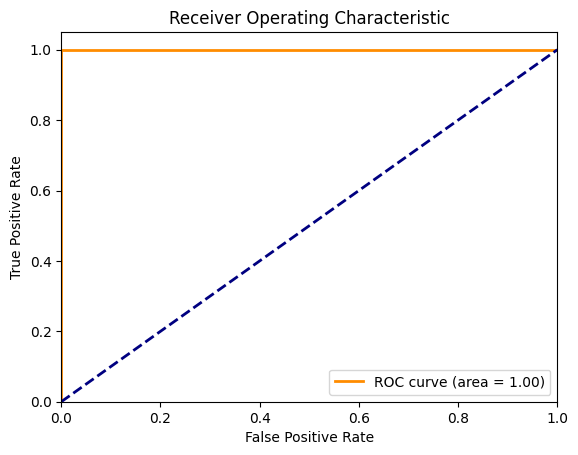

In [4]:
#Baseline classification between benign and attack traffic

num_rows = 5000
attack_name = "SSH-Patator"
df_attack_norm = create_normalized_dataframe(df, attack_name)
df_benign_norm = create_normalized_dataframe(df, "BENIGN")
df_benign_norm = df_benign_norm.dropna()
df_attack_norm = df_attack_norm.dropna()


combined_df = pd.concat([df_attack_norm[:num_rows], df_benign_norm[:num_rows]])
combined_df = combined_df.sample(frac=1)

y = combined_df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(combined_df.iloc[:,:-1], \
                                                    y, test_size=.2, random_state=42)


# Instantiate the encoder
le = LabelEncoder()

# Fit and transform the target variable
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


# Create a Random Forest classifier object
classifier = RandomForestClassifier()


# Fit the classifier on the training data
classifier.fit(X_train, y_train)

# Use the classifier to predict the labels for the test data
y_pred = classifier.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Print the accuracy score
acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

# Print the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC: ", roc_auc)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5000
           1       1.00      0.99      1.00      5000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

Confusion Matrix:
 [[5000    0]
 [  40 4960]]
Accuracy:  0.996
ROC AUC:  0.996


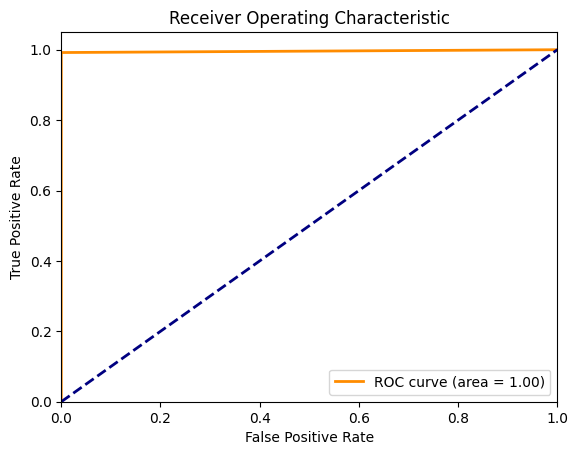

In [5]:
#Now training the model on generated data and testing with real, to asses how useful the generated data is.

num_train_rows = 5000
num_test_rows = 5000
attack_name = "SSH-Patator"
lbl = df.columns
df_attack_norm = create_normalized_dataframe(df, attack_name)
df_benign_norm = create_normalized_dataframe(df, "BENIGN")
df_benign_norm = df_benign_norm.dropna()
df_attack_norm = df_attack_norm.dropna()


df_generated_samples[' Label'] = "SSH-Patator"
df_gensamples_norm = create_normalized_dataframe(df_generated_samples, attack_name)

df_train = pd.concat([df_gensamples_norm[:num_train_rows], df_benign_norm[:num_train_rows]])
df_train = df_train.sample(frac=1)

X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]


# Use original data for testing
df_test = pd.concat([df_attack_norm[:num_test_rows], df_benign_norm[num_train_rows:num_train_rows+num_test_rows]])
#df_test = pd.concat([df_attack_norm[:num_test_rows], df_benign_norm[:num_train_rows]])
df_test = df_test.sample(frac=1)


X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]


# Instantiate the encoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Create a Random Forest classifier object
classifier = gboost()


# Fit the classifier on the training data
classifier.fit(X_train, y_train)

# Use the classifier to predict the labels for the test data
y_pred = classifier.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Print the accuracy score
acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

# Print the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC: ", roc_auc)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Confusion Matrix:
 [[1000    0]
 [   0 1000]]
Accuracy:  1.0
ROC AUC:  1.0


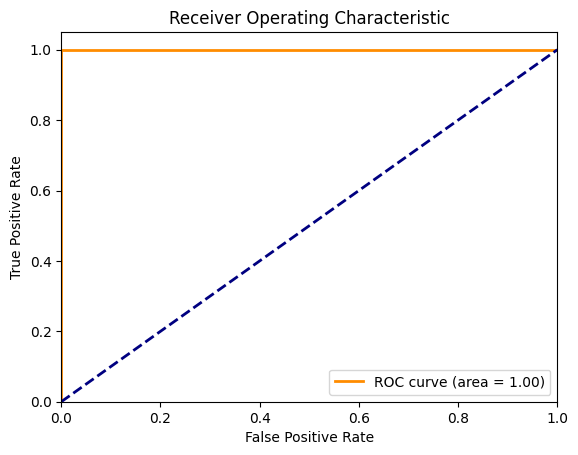

In [6]:
#Train with both.
#Test with real.
#Classifier between normal and attack data

num_train_rows = 8000
num_test_rows = 1000
num_test_rows_attack = 1000

gen_in_train = 4000
real_in_train = 4000

attack_name = "SSH-Patator"
df_generated_samples[' Label'] = "SSH-Patator"
lbl = df.columns

df_attack_norm = create_normalized_dataframe(df, attack_name)
df_benign_norm = create_normalized_dataframe(df, "BENIGN")
df_gensamples_norm = create_normalized_dataframe(df_generated_samples, attack_name)

df_benign_norm = df_benign_norm.dropna()

df_training_mix = pd.concat([df_attack_norm[:real_in_train], df_gensamples_norm[:gen_in_train]])

df_train = pd.concat([df_training_mix[:num_train_rows], df_benign_norm[:num_train_rows]])
df_train = df_train.sample(frac=1)

X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]


# Use original data for testing
df_test = pd.concat([df_attack_norm[real_in_train:real_in_train + num_test_rows_attack], df_benign_norm[num_train_rows:num_train_rows+num_test_rows]])
df_test = df_test.sample(frac=1)


X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]


# Instantiate the encoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Create a Random Forest classifier object
classifier = gboost()


# Fit the classifier on the training data
classifier.fit(X_train, y_train)

# Use the classifier to predict the labels for the test data
y_pred = classifier.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Print the accuracy score
acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

# Print the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC: ", roc_auc)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()